<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[02:57:13] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


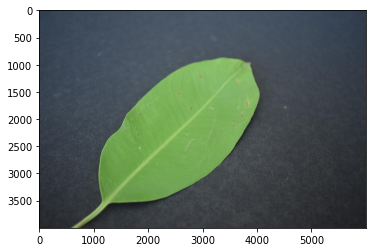

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

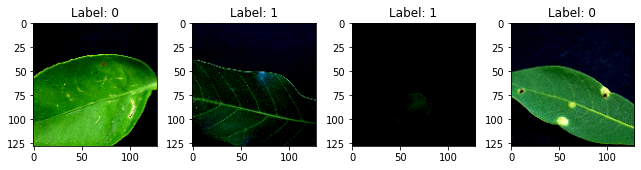

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[02:57:18] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[02:57:20] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2568266827079746 samples/sec                   batch loss = 0.8538883924484253 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2568877905153053 samples/sec                   batch loss = 1.1066416501998901 | accuracy = 0.575


Epoch[1] Batch[15] Speed: 1.2692317876245556 samples/sec                   batch loss = 0.6938493847846985 | accuracy = 0.55


Epoch[1] Batch[20] Speed: 1.270077038639687 samples/sec                   batch loss = 0.6178151369094849 | accuracy = 0.5875


Epoch[1] Batch[25] Speed: 1.270673051179434 samples/sec                   batch loss = 0.42269736528396606 | accuracy = 0.57


Epoch[1] Batch[30] Speed: 1.2691119658992485 samples/sec                   batch loss = 0.7521569132804871 | accuracy = 0.5916666666666667


Epoch[1] Batch[35] Speed: 1.2744017407661565 samples/sec                   batch loss = 0.5590265989303589 | accuracy = 0.5714285714285714


Epoch[1] Batch[40] Speed: 1.2709122482638338 samples/sec                   batch loss = 1.2307946681976318 | accuracy = 0.58125


Epoch[1] Batch[45] Speed: 1.272791509087062 samples/sec                   batch loss = 0.4500955641269684 | accuracy = 0.5833333333333334


Epoch[1] Batch[50] Speed: 1.2659869447390268 samples/sec                   batch loss = 0.34515565633773804 | accuracy = 0.59


Epoch[1] Batch[55] Speed: 1.2697092829258352 samples/sec                   batch loss = 0.3331924378871918 | accuracy = 0.5954545454545455


Epoch[1] Batch[60] Speed: 1.2728110143885651 samples/sec                   batch loss = 0.5202412605285645 | accuracy = 0.6083333333333333


Epoch[1] Batch[65] Speed: 1.2675977122637838 samples/sec                   batch loss = 0.9827272891998291 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.261654265610411 samples/sec                   batch loss = 0.4872177839279175 | accuracy = 0.6107142857142858


Epoch[1] Batch[75] Speed: 1.2662511395698424 samples/sec                   batch loss = 0.7875897288322449 | accuracy = 0.61


Epoch[1] Batch[80] Speed: 1.264407804363805 samples/sec                   batch loss = 0.6521011590957642 | accuracy = 0.609375


Epoch[1] Batch[85] Speed: 1.2654349281640915 samples/sec                   batch loss = 0.49184417724609375 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.2597313879092271 samples/sec                   batch loss = 0.6872584819793701 | accuracy = 0.6305555555555555


Epoch[1] Batch[95] Speed: 1.267877047813849 samples/sec                   batch loss = 0.6441988348960876 | accuracy = 0.6236842105263158


Epoch[1] Batch[100] Speed: 1.2614902446486607 samples/sec                   batch loss = 0.4557580053806305 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.2632743752643867 samples/sec                   batch loss = 0.5760046243667603 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2672357937649206 samples/sec                   batch loss = 0.49481436610221863 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.2691197421035436 samples/sec                   batch loss = 0.5653249621391296 | accuracy = 0.6282608695652174


Epoch[1] Batch[120] Speed: 1.2659590506719676 samples/sec                   batch loss = 0.5103327035903931 | accuracy = 0.625


Epoch[1] Batch[125] Speed: 1.2699668625954725 samples/sec                   batch loss = 0.43983209133148193 | accuracy = 0.63


Epoch[1] Batch[130] Speed: 1.2646823036384947 samples/sec                   batch loss = 0.36661532521247864 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.273108012987553 samples/sec                   batch loss = 0.25284692645072937 | accuracy = 0.6388888888888888


Epoch[1] Batch[140] Speed: 1.27597684516296 samples/sec                   batch loss = 0.7001552581787109 | accuracy = 0.6410714285714286


Epoch[1] Batch[145] Speed: 1.261799633882009 samples/sec                   batch loss = 1.3074668645858765 | accuracy = 0.6431034482758621


Epoch[1] Batch[150] Speed: 1.2694605486371842 samples/sec                   batch loss = 0.8235476613044739 | accuracy = 0.6416666666666667


Epoch[1] Batch[155] Speed: 1.270752548951974 samples/sec                   batch loss = 0.5836848020553589 | accuracy = 0.6451612903225806


Epoch[1] Batch[160] Speed: 1.265417461706473 samples/sec                   batch loss = 0.665760338306427 | accuracy = 0.6515625


Epoch[1] Batch[165] Speed: 1.2655270406841679 samples/sec                   batch loss = 0.5866585969924927 | accuracy = 0.6530303030303031


Epoch[1] Batch[170] Speed: 1.2725343267726261 samples/sec                   batch loss = 0.5542082190513611 | accuracy = 0.65


Epoch[1] Batch[175] Speed: 1.268510990507801 samples/sec                   batch loss = 0.6525529623031616 | accuracy = 0.6528571428571428


Epoch[1] Batch[180] Speed: 1.2672311035856885 samples/sec                   batch loss = 0.5812050700187683 | accuracy = 0.6555555555555556


Epoch[1] Batch[185] Speed: 1.2663226296722359 samples/sec                   batch loss = 0.5297499895095825 | accuracy = 0.6581081081081082


Epoch[1] Batch[190] Speed: 1.2662096637187563 samples/sec                   batch loss = 0.3065260052680969 | accuracy = 0.6578947368421053


Epoch[1] Batch[195] Speed: 1.2724419634534678 samples/sec                   batch loss = 0.540176510810852 | accuracy = 0.6564102564102564


Epoch[1] Batch[200] Speed: 1.274012998152071 samples/sec                   batch loss = 0.7306556701660156 | accuracy = 0.6575


Epoch[1] Batch[205] Speed: 1.2720682075146668 samples/sec                   batch loss = 0.8161329627037048 | accuracy = 0.6573170731707317


Epoch[1] Batch[210] Speed: 1.2653812895379424 samples/sec                   batch loss = 0.6520370244979858 | accuracy = 0.6583333333333333


Epoch[1] Batch[215] Speed: 1.273605059070389 samples/sec                   batch loss = 0.4555194675922394 | accuracy = 0.6627906976744186


Epoch[1] Batch[220] Speed: 1.2696642172258001 samples/sec                   batch loss = 0.892949640750885 | accuracy = 0.6602272727272728


Epoch[1] Batch[225] Speed: 1.271905035547988 samples/sec                   batch loss = 0.38368988037109375 | accuracy = 0.6633333333333333


Epoch[1] Batch[230] Speed: 1.2758578811328243 samples/sec                   batch loss = 0.29248160123825073 | accuracy = 0.6641304347826087


Epoch[1] Batch[235] Speed: 1.269578706888267 samples/sec                   batch loss = 0.4001500904560089 | accuracy = 0.6638297872340425


Epoch[1] Batch[240] Speed: 1.2702450314047895 samples/sec                   batch loss = 0.650199294090271 | accuracy = 0.6635416666666667


Epoch[1] Batch[245] Speed: 1.2738031931451639 samples/sec                   batch loss = 0.4100925922393799 | accuracy = 0.6653061224489796


Epoch[1] Batch[250] Speed: 1.2756880125649508 samples/sec                   batch loss = 0.358232706785202 | accuracy = 0.671


Epoch[1] Batch[255] Speed: 1.2727438105217848 samples/sec                   batch loss = 0.3848465383052826 | accuracy = 0.6705882352941176


Epoch[1] Batch[260] Speed: 1.270984169378941 samples/sec                   batch loss = 0.2965488135814667 | accuracy = 0.6711538461538461


Epoch[1] Batch[265] Speed: 1.2728988922196962 samples/sec                   batch loss = 0.5477795600891113 | accuracy = 0.6698113207547169


Epoch[1] Batch[270] Speed: 1.2758058777263375 samples/sec                   batch loss = 0.3910526633262634 | accuracy = 0.6731481481481482


Epoch[1] Batch[275] Speed: 1.2716782844684276 samples/sec                   batch loss = 0.5258966088294983 | accuracy = 0.6736363636363636


Epoch[1] Batch[280] Speed: 1.269490902641282 samples/sec                   batch loss = 0.7889881730079651 | accuracy = 0.675


Epoch[1] Batch[285] Speed: 1.2642533556124003 samples/sec                   batch loss = 0.5773712992668152 | accuracy = 0.6728070175438596


Epoch[1] Batch[290] Speed: 1.2599940189168652 samples/sec                   batch loss = 0.72765052318573 | accuracy = 0.6732758620689655


Epoch[1] Batch[295] Speed: 1.2652304194972537 samples/sec                   batch loss = 0.5523220300674438 | accuracy = 0.673728813559322


Epoch[1] Batch[300] Speed: 1.2635421019129196 samples/sec                   batch loss = 0.34608837962150574 | accuracy = 0.6758333333333333


Epoch[1] Batch[305] Speed: 1.266511907149725 samples/sec                   batch loss = 0.5763823986053467 | accuracy = 0.6737704918032786


Epoch[1] Batch[310] Speed: 1.2671241003568703 samples/sec                   batch loss = 0.9885070323944092 | accuracy = 0.6741935483870968


Epoch[1] Batch[315] Speed: 1.272138330315105 samples/sec                   batch loss = 0.5585207939147949 | accuracy = 0.676984126984127


Epoch[1] Batch[320] Speed: 1.2691949169916208 samples/sec                   batch loss = 1.0953419208526611 | accuracy = 0.67578125


Epoch[1] Batch[325] Speed: 1.2707772857601 samples/sec                   batch loss = 0.4988163411617279 | accuracy = 0.6730769230769231


Epoch[1] Batch[330] Speed: 1.272327034724442 samples/sec                   batch loss = 0.3862599730491638 | accuracy = 0.6727272727272727


Epoch[1] Batch[335] Speed: 1.2720401412699267 samples/sec                   batch loss = 0.377692848443985 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2632662900484406 samples/sec                   batch loss = 0.40558138489723206 | accuracy = 0.6720588235294118


Epoch[1] Batch[345] Speed: 1.265960483556421 samples/sec                   batch loss = 0.17568765580654144 | accuracy = 0.6739130434782609


Epoch[1] Batch[350] Speed: 1.2707609227830858 samples/sec                   batch loss = 0.7433342933654785 | accuracy = 0.6714285714285714


Epoch[1] Batch[355] Speed: 1.2645545704010608 samples/sec                   batch loss = 0.3487894535064697 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.2681384855611553 samples/sec                   batch loss = 0.37654995918273926 | accuracy = 0.6743055555555556


Epoch[1] Batch[365] Speed: 1.267660542452292 samples/sec                   batch loss = 0.32683587074279785 | accuracy = 0.6760273972602739


Epoch[1] Batch[370] Speed: 1.2646901209879096 samples/sec                   batch loss = 0.6597932577133179 | accuracy = 0.6736486486486486


Epoch[1] Batch[375] Speed: 1.2658031722156726 samples/sec                   batch loss = 0.6536003947257996 | accuracy = 0.6733333333333333


Epoch[1] Batch[380] Speed: 1.2708497691903835 samples/sec                   batch loss = 1.0675549507141113 | accuracy = 0.6730263157894737


Epoch[1] Batch[385] Speed: 1.2660644240929932 samples/sec                   batch loss = 0.46033990383148193 | accuracy = 0.6733766233766234


Epoch[1] Batch[390] Speed: 1.2712926463293783 samples/sec                   batch loss = 0.30874577164649963 | accuracy = 0.675


Epoch[1] Batch[395] Speed: 1.276191638203682 samples/sec                   batch loss = 0.533595621585846 | accuracy = 0.6753164556962026


Epoch[1] Batch[400] Speed: 1.2684709009626327 samples/sec                   batch loss = 0.35472360253334045 | accuracy = 0.678125


Epoch[1] Batch[405] Speed: 1.2739344461835498 samples/sec                   batch loss = 0.5049750208854675 | accuracy = 0.6796296296296296


Epoch[1] Batch[410] Speed: 1.2676524967755634 samples/sec                   batch loss = 0.3997846841812134 | accuracy = 0.6817073170731708


Epoch[1] Batch[415] Speed: 1.2638141309429272 samples/sec                   batch loss = 0.6671311259269714 | accuracy = 0.6807228915662651


Epoch[1] Batch[420] Speed: 1.2754113332943602 samples/sec                   batch loss = 0.3150957524776459 | accuracy = 0.680952380952381


Epoch[1] Batch[425] Speed: 1.269335113622831 samples/sec                   batch loss = 0.33133459091186523 | accuracy = 0.6811764705882353


Epoch[1] Batch[430] Speed: 1.2689810327710114 samples/sec                   batch loss = 0.5294735431671143 | accuracy = 0.6819767441860465


Epoch[1] Batch[435] Speed: 1.2644130454213645 samples/sec                   batch loss = 0.7109965682029724 | accuracy = 0.6816091954022988


Epoch[1] Batch[440] Speed: 1.2671276413195056 samples/sec                   batch loss = 0.5114701390266418 | accuracy = 0.6823863636363636


Epoch[1] Batch[445] Speed: 1.2663373492248058 samples/sec                   batch loss = 0.5452972650527954 | accuracy = 0.6831460674157304


Epoch[1] Batch[450] Speed: 1.2653943647269583 samples/sec                   batch loss = 0.6032976508140564 | accuracy = 0.6833333333333333


Epoch[1] Batch[455] Speed: 1.2703814199738914 samples/sec                   batch loss = 0.6237822771072388 | accuracy = 0.6846153846153846


Epoch[1] Batch[460] Speed: 1.2651714554088043 samples/sec                   batch loss = 0.20568476617336273 | accuracy = 0.6842391304347826


Epoch[1] Batch[465] Speed: 1.275209015445207 samples/sec                   batch loss = 1.0145541429519653 | accuracy = 0.682258064516129


Epoch[1] Batch[470] Speed: 1.2661716306491249 samples/sec                   batch loss = 0.41946566104888916 | accuracy = 0.6835106382978723


Epoch[1] Batch[475] Speed: 1.2656909673135763 samples/sec                   batch loss = 0.388142466545105 | accuracy = 0.6836842105263158


Epoch[1] Batch[480] Speed: 1.2679418221941754 samples/sec                   batch loss = 0.4725498557090759 | accuracy = 0.6848958333333334


Epoch[1] Batch[485] Speed: 1.2681050331489137 samples/sec                   batch loss = 0.43587005138397217 | accuracy = 0.6855670103092784


Epoch[1] Batch[490] Speed: 1.2632663851680266 samples/sec                   batch loss = 0.8524066805839539 | accuracy = 0.686734693877551


Epoch[1] Batch[495] Speed: 1.2733176856745294 samples/sec                   batch loss = 0.34773966670036316 | accuracy = 0.6883838383838384


Epoch[1] Batch[500] Speed: 1.269566409719682 samples/sec                   batch loss = 0.4144270122051239 | accuracy = 0.6885


Epoch[1] Batch[505] Speed: 1.2691968372842064 samples/sec                   batch loss = 0.5536993741989136 | accuracy = 0.69009900990099


Epoch[1] Batch[510] Speed: 1.2737817232252282 samples/sec                   batch loss = 0.536113440990448 | accuracy = 0.6892156862745098


Epoch[1] Batch[515] Speed: 1.2710213366257086 samples/sec                   batch loss = 0.1497918665409088 | accuracy = 0.6907766990291262


Epoch[1] Batch[520] Speed: 1.271704599642575 samples/sec                   batch loss = 0.5090596675872803 | accuracy = 0.6899038461538461


Epoch[1] Batch[525] Speed: 1.273768764254456 samples/sec                   batch loss = 0.45310384035110474 | accuracy = 0.6919047619047619


Epoch[1] Batch[530] Speed: 1.268898589481233 samples/sec                   batch loss = 0.4482955038547516 | accuracy = 0.6924528301886792


Epoch[1] Batch[535] Speed: 1.2683335799106772 samples/sec                   batch loss = 0.735295295715332 | accuracy = 0.6929906542056075


Epoch[1] Batch[540] Speed: 1.2737586100213152 samples/sec                   batch loss = 0.35559484362602234 | accuracy = 0.6935185185185185


Epoch[1] Batch[545] Speed: 1.2747502332427816 samples/sec                   batch loss = 0.5180140733718872 | accuracy = 0.694954128440367


Epoch[1] Batch[550] Speed: 1.2691406711267443 samples/sec                   batch loss = 0.7107706069946289 | accuracy = 0.6954545454545454


Epoch[1] Batch[555] Speed: 1.2732240491069446 samples/sec                   batch loss = 0.27039194107055664 | accuracy = 0.6972972972972973


Epoch[1] Batch[560] Speed: 1.2719277922462302 samples/sec                   batch loss = 0.7783948183059692 | accuracy = 0.6973214285714285


Epoch[1] Batch[565] Speed: 1.2693430846357292 samples/sec                   batch loss = 0.3380240201950073 | accuracy = 0.6960176991150443


Epoch[1] Batch[570] Speed: 1.2643332907548561 samples/sec                   batch loss = 0.9631771445274353 | accuracy = 0.6969298245614035


Epoch[1] Batch[575] Speed: 1.2689791131313934 samples/sec                   batch loss = 0.6449693441390991 | accuracy = 0.6965217391304348


Epoch[1] Batch[580] Speed: 1.2691843554862676 samples/sec                   batch loss = 0.5143426656723022 | accuracy = 0.6969827586206897


Epoch[1] Batch[585] Speed: 1.2705832672313395 samples/sec                   batch loss = 0.4080544412136078 | accuracy = 0.6974358974358974


Epoch[1] Batch[590] Speed: 1.2680114907857782 samples/sec                   batch loss = 0.5484273433685303 | accuracy = 0.6974576271186441


Epoch[1] Batch[595] Speed: 1.2669459293589889 samples/sec                   batch loss = 0.19165001809597015 | accuracy = 0.6974789915966386


Epoch[1] Batch[600] Speed: 1.2661014952513692 samples/sec                   batch loss = 0.3941226005554199 | accuracy = 0.6975


Epoch[1] Batch[605] Speed: 1.264051133400846 samples/sec                   batch loss = 0.8739109635353088 | accuracy = 0.6979338842975207


Epoch[1] Batch[610] Speed: 1.2645291221596133 samples/sec                   batch loss = 0.34327247738838196 | accuracy = 0.6983606557377049


Epoch[1] Batch[615] Speed: 1.2699639786625787 samples/sec                   batch loss = 0.5224265456199646 | accuracy = 0.697560975609756


Epoch[1] Batch[620] Speed: 1.2598604191450662 samples/sec                   batch loss = 0.5802693367004395 | accuracy = 0.697983870967742


Epoch[1] Batch[625] Speed: 1.2607633362688393 samples/sec                   batch loss = 0.5437057018280029 | accuracy = 0.6988


Epoch[1] Batch[630] Speed: 1.2642214415435284 samples/sec                   batch loss = 0.47107458114624023 | accuracy = 0.6988095238095238


Epoch[1] Batch[635] Speed: 1.268698428360221 samples/sec                   batch loss = 0.45683133602142334 | accuracy = 0.6988188976377953


Epoch[1] Batch[640] Speed: 1.2647970949167602 samples/sec                   batch loss = 0.540289580821991 | accuracy = 0.7


Epoch[1] Batch[645] Speed: 1.267152237200715 samples/sec                   batch loss = 0.791143536567688 | accuracy = 0.6984496124031008


Epoch[1] Batch[650] Speed: 1.2697984628650605 samples/sec                   batch loss = 0.39684832096099854 | accuracy = 0.6984615384615385


Epoch[1] Batch[655] Speed: 1.262468360626514 samples/sec                   batch loss = 1.1423439979553223 | accuracy = 0.6984732824427481


Epoch[1] Batch[660] Speed: 1.269987242761253 samples/sec                   batch loss = 0.6923031210899353 | accuracy = 0.6977272727272728


Epoch[1] Batch[665] Speed: 1.2595387416351211 samples/sec                   batch loss = 0.20778994262218475 | accuracy = 0.6984962406015037


Epoch[1] Batch[670] Speed: 1.262722535329358 samples/sec                   batch loss = 0.3546341061592102 | accuracy = 0.6977611940298507


Epoch[1] Batch[675] Speed: 1.2678201361432526 samples/sec                   batch loss = 0.6326959729194641 | accuracy = 0.6966666666666667


Epoch[1] Batch[680] Speed: 1.270978199712899 samples/sec                   batch loss = 0.6377869248390198 | accuracy = 0.6959558823529411


Epoch[1] Batch[685] Speed: 1.2661690505990169 samples/sec                   batch loss = 0.7433633208274841 | accuracy = 0.6945255474452555


Epoch[1] Batch[690] Speed: 1.2770337453934857 samples/sec                   batch loss = 0.41161978244781494 | accuracy = 0.6949275362318841


Epoch[1] Batch[695] Speed: 1.2702554182203631 samples/sec                   batch loss = 0.5368033051490784 | accuracy = 0.6953237410071943


Epoch[1] Batch[700] Speed: 1.2465489272513546 samples/sec                   batch loss = 0.7871788144111633 | accuracy = 0.695


Epoch[1] Batch[705] Speed: 1.2694853312279686 samples/sec                   batch loss = 0.6520529985427856 | accuracy = 0.6939716312056737


Epoch[1] Batch[710] Speed: 1.2689027161898163 samples/sec                   batch loss = 0.1867358386516571 | accuracy = 0.6954225352112676


Epoch[1] Batch[715] Speed: 1.2702400304060217 samples/sec                   batch loss = 0.26421040296554565 | accuracy = 0.6961538461538461


Epoch[1] Batch[720] Speed: 1.27100737458121 samples/sec                   batch loss = 0.33795320987701416 | accuracy = 0.6972222222222222


Epoch[1] Batch[725] Speed: 1.2715937555447239 samples/sec                   batch loss = 0.8174890279769897 | accuracy = 0.6975862068965517


Epoch[1] Batch[730] Speed: 1.266491351553906 samples/sec                   batch loss = 0.3844813406467438 | accuracy = 0.6982876712328767


Epoch[1] Batch[735] Speed: 1.2687449606661607 samples/sec                   batch loss = 0.7997252345085144 | accuracy = 0.6986394557823129


Epoch[1] Batch[740] Speed: 1.2742168721549414 samples/sec                   batch loss = 0.3570064902305603 | accuracy = 0.6983108108108108


Epoch[1] Batch[745] Speed: 1.2714897724337715 samples/sec                   batch loss = 0.5407862663269043 | accuracy = 0.6986577181208053


Epoch[1] Batch[750] Speed: 1.2717667771826888 samples/sec                   batch loss = 0.5632163882255554 | accuracy = 0.6983333333333334


Epoch[1] Batch[755] Speed: 1.2666314296458603 samples/sec                   batch loss = 0.4148465096950531 | accuracy = 0.6986754966887417


Epoch[1] Batch[760] Speed: 1.26700505896818 samples/sec                   batch loss = 0.4992058575153351 | accuracy = 0.6980263157894737


Epoch[1] Batch[765] Speed: 1.2660339471120505 samples/sec                   batch loss = 0.8763822913169861 | accuracy = 0.6983660130718954


Epoch[1] Batch[770] Speed: 1.2699353323070735 samples/sec                   batch loss = 1.8939601182937622 | accuracy = 0.698051948051948


Epoch[1] Batch[775] Speed: 1.2690551352993387 samples/sec                   batch loss = 0.5255901217460632 | accuracy = 0.697741935483871


Epoch[1] Batch[780] Speed: 1.2704823355855195 samples/sec                   batch loss = 0.590903103351593 | accuracy = 0.6983974358974359


Epoch[1] Batch[785] Speed: 1.2658304863768606 samples/sec                   batch loss = 1.4301820993423462 | accuracy = 0.697452229299363


[Epoch 1] training: accuracy=0.6976522842639594
[Epoch 1] time cost: 658.9229998588562
[Epoch 1] validation: validation accuracy=0.6944444444444444


Epoch[2] Batch[5] Speed: 1.2643168074727342 samples/sec                   batch loss = 0.42507845163345337 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2703172617591423 samples/sec                   batch loss = 0.7414014339447021 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2682052039511071 samples/sec                   batch loss = 0.2656983733177185 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2596247016904445 samples/sec                   batch loss = 0.45272088050842285 | accuracy = 0.7125


Epoch[2] Batch[25] Speed: 1.2614505976305606 samples/sec                   batch loss = 0.8819074630737305 | accuracy = 0.69


Epoch[2] Batch[30] Speed: 1.2573636742515966 samples/sec                   batch loss = 1.809281826019287 | accuracy = 0.6666666666666666


Epoch[2] Batch[35] Speed: 1.2573106234447755 samples/sec                   batch loss = 0.6282206177711487 | accuracy = 0.6642857142857143


Epoch[2] Batch[40] Speed: 1.2618274398545062 samples/sec                   batch loss = 0.9313154816627502 | accuracy = 0.6625


Epoch[2] Batch[45] Speed: 1.2643533952240809 samples/sec                   batch loss = 0.6581937074661255 | accuracy = 0.6611111111111111


Epoch[2] Batch[50] Speed: 1.2599238092720548 samples/sec                   batch loss = 0.28188028931617737 | accuracy = 0.67


Epoch[2] Batch[55] Speed: 1.2582967050480847 samples/sec                   batch loss = 0.4432317912578583 | accuracy = 0.6727272727272727


Epoch[2] Batch[60] Speed: 1.266781677515379 samples/sec                   batch loss = 0.25035011768341064 | accuracy = 0.6833333333333333


Epoch[2] Batch[65] Speed: 1.2601136393509114 samples/sec                   batch loss = 1.5144288539886475 | accuracy = 0.6884615384615385


Epoch[2] Batch[70] Speed: 1.259348895653737 samples/sec                   batch loss = 0.44420358538627625 | accuracy = 0.6857142857142857


Epoch[2] Batch[75] Speed: 1.2578412387428708 samples/sec                   batch loss = 0.22238992154598236 | accuracy = 0.7


Epoch[2] Batch[80] Speed: 1.261873469498887 samples/sec                   batch loss = 2.659637451171875 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2621518068391693 samples/sec                   batch loss = 0.46561944484710693 | accuracy = 0.7029411764705882


Epoch[2] Batch[90] Speed: 1.2603321188166057 samples/sec                   batch loss = 0.11205074936151505 | accuracy = 0.7083333333333334


Epoch[2] Batch[95] Speed: 1.254853810328712 samples/sec                   batch loss = 1.3370707035064697 | accuracy = 0.7


Epoch[2] Batch[100] Speed: 1.2648566916292399 samples/sec                   batch loss = 0.29864373803138733 | accuracy = 0.71


Epoch[2] Batch[105] Speed: 1.2738877259001267 samples/sec                   batch loss = 0.44171077013015747 | accuracy = 0.7142857142857143


Epoch[2] Batch[110] Speed: 1.2613185853355577 samples/sec                   batch loss = 0.7576879858970642 | accuracy = 0.7159090909090909


Epoch[2] Batch[115] Speed: 1.2647281604454028 samples/sec                   batch loss = 0.2279980182647705 | accuracy = 0.7195652173913043


Epoch[2] Batch[120] Speed: 1.264654371703947 samples/sec                   batch loss = 0.4184398651123047 | accuracy = 0.725


Epoch[2] Batch[125] Speed: 1.2741394562121493 samples/sec                   batch loss = 0.21740399301052094 | accuracy = 0.732


Epoch[2] Batch[130] Speed: 1.271903782024714 samples/sec                   batch loss = 0.23801717162132263 | accuracy = 0.7307692307692307


Epoch[2] Batch[135] Speed: 1.270268498155685 samples/sec                   batch loss = 0.2121051400899887 | accuracy = 0.7296296296296296


Epoch[2] Batch[140] Speed: 1.2666352547382322 samples/sec                   batch loss = 0.4929659068584442 | accuracy = 0.7339285714285714


Epoch[2] Batch[145] Speed: 1.2659354563077552 samples/sec                   batch loss = 1.051839828491211 | accuracy = 0.7362068965517241


Epoch[2] Batch[150] Speed: 1.2684799160940485 samples/sec                   batch loss = 0.6629049181938171 | accuracy = 0.7366666666666667


Epoch[2] Batch[155] Speed: 1.2706432180206197 samples/sec                   batch loss = 0.4962148070335388 | accuracy = 0.7290322580645161


Epoch[2] Batch[160] Speed: 1.2686704146798182 samples/sec                   batch loss = 0.9015268087387085 | accuracy = 0.7234375


Epoch[2] Batch[165] Speed: 1.2718305034199193 samples/sec                   batch loss = 0.2703162133693695 | accuracy = 0.7227272727272728


Epoch[2] Batch[170] Speed: 1.2694975307656424 samples/sec                   batch loss = 1.2253265380859375 | accuracy = 0.725


Epoch[2] Batch[175] Speed: 1.2642187741719293 samples/sec                   batch loss = 0.7923917174339294 | accuracy = 0.7271428571428571


Epoch[2] Batch[180] Speed: 1.2623467730364033 samples/sec                   batch loss = 0.7884554862976074 | accuracy = 0.7263888888888889


Epoch[2] Batch[185] Speed: 1.2717068167216417 samples/sec                   batch loss = 0.782683789730072 | accuracy = 0.727027027027027


Epoch[2] Batch[190] Speed: 1.2691975093879841 samples/sec                   batch loss = 0.3104017674922943 | accuracy = 0.7315789473684211


Epoch[2] Batch[195] Speed: 1.2639481897152993 samples/sec                   batch loss = 0.3210331201553345 | accuracy = 0.7307692307692307


Epoch[2] Batch[200] Speed: 1.2640109443238865 samples/sec                   batch loss = 0.44937723875045776 | accuracy = 0.7325


Epoch[2] Batch[205] Speed: 1.2589904432922046 samples/sec                   batch loss = 0.4992603659629822 | accuracy = 0.7353658536585366


Epoch[2] Batch[210] Speed: 1.2659714691116597 samples/sec                   batch loss = 0.5633354783058167 | accuracy = 0.7345238095238096


Epoch[2] Batch[215] Speed: 1.2629403993450892 samples/sec                   batch loss = 0.3598115146160126 | accuracy = 0.7372093023255814


Epoch[2] Batch[220] Speed: 1.2597505895642453 samples/sec                   batch loss = 0.31279605627059937 | accuracy = 0.7363636363636363


Epoch[2] Batch[225] Speed: 1.266280288971148 samples/sec                   batch loss = 0.4894757568836212 | accuracy = 0.7366666666666667


Epoch[2] Batch[230] Speed: 1.266807216502396 samples/sec                   batch loss = 0.3878403306007385 | accuracy = 0.7336956521739131


Epoch[2] Batch[235] Speed: 1.266619763256813 samples/sec                   batch loss = 0.5290586352348328 | accuracy = 0.7372340425531915


Epoch[2] Batch[240] Speed: 1.264905231341531 samples/sec                   batch loss = 0.7591465711593628 | accuracy = 0.734375


Epoch[2] Batch[245] Speed: 1.2652765069074219 samples/sec                   batch loss = 0.12864349782466888 | accuracy = 0.7377551020408163


Epoch[2] Batch[250] Speed: 1.263978185450342 samples/sec                   batch loss = 0.23511472344398499 | accuracy = 0.739


Epoch[2] Batch[255] Speed: 1.2666988502838163 samples/sec                   batch loss = 0.8182221055030823 | accuracy = 0.7401960784313726


Epoch[2] Batch[260] Speed: 1.2650238784603447 samples/sec                   batch loss = 0.41114917397499084 | accuracy = 0.7413461538461539


Epoch[2] Batch[265] Speed: 1.2701830025703897 samples/sec                   batch loss = 0.43539783358573914 | accuracy = 0.7415094339622641


Epoch[2] Batch[270] Speed: 1.271726481587378 samples/sec                   batch loss = 1.0137672424316406 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.260876185311316 samples/sec                   batch loss = 0.45622214674949646 | accuracy = 0.7418181818181818


Epoch[2] Batch[280] Speed: 1.2570951682295672 samples/sec                   batch loss = 0.650838315486908 | accuracy = 0.7410714285714286


Epoch[2] Batch[285] Speed: 1.2638973430548541 samples/sec                   batch loss = 0.5170308947563171 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.2647527586060805 samples/sec                   batch loss = 0.21725346148014069 | accuracy = 0.7448275862068966


Epoch[2] Batch[295] Speed: 1.257554524559513 samples/sec                   batch loss = 1.3398441076278687 | accuracy = 0.7440677966101695


Epoch[2] Batch[300] Speed: 1.2571862589969676 samples/sec                   batch loss = 0.4309617877006531 | accuracy = 0.7433333333333333


Epoch[2] Batch[305] Speed: 1.2704213417739252 samples/sec                   batch loss = 0.2497635781764984 | accuracy = 0.7418032786885246


Epoch[2] Batch[310] Speed: 1.2613626811968484 samples/sec                   batch loss = 0.5473769903182983 | accuracy = 0.7435483870967742


Epoch[2] Batch[315] Speed: 1.2723046496801231 samples/sec                   batch loss = 0.7578684687614441 | accuracy = 0.7412698412698413


Epoch[2] Batch[320] Speed: 1.2615980060736698 samples/sec                   batch loss = 0.6901392340660095 | accuracy = 0.7390625


Epoch[2] Batch[325] Speed: 1.2577818298034753 samples/sec                   batch loss = 0.4048454165458679 | accuracy = 0.74


Epoch[2] Batch[330] Speed: 1.2651837629928144 samples/sec                   batch loss = 0.42035356163978577 | accuracy = 0.7401515151515151


Epoch[2] Batch[335] Speed: 1.262438151522984 samples/sec                   batch loss = 0.40076908469200134 | accuracy = 0.7432835820895523


Epoch[2] Batch[340] Speed: 1.2654046723657038 samples/sec                   batch loss = 0.4385135769844055 | accuracy = 0.7426470588235294


Epoch[2] Batch[345] Speed: 1.2605911169781487 samples/sec                   batch loss = 0.34551769495010376 | accuracy = 0.7456521739130435


Epoch[2] Batch[350] Speed: 1.2624067089916482 samples/sec                   batch loss = 0.40249207615852356 | accuracy = 0.745


Epoch[2] Batch[355] Speed: 1.2603801225055375 samples/sec                   batch loss = 0.6514055132865906 | accuracy = 0.7450704225352113


Epoch[2] Batch[360] Speed: 1.260236690390791 samples/sec                   batch loss = 0.0635669007897377 | accuracy = 0.7465277777777778


Epoch[2] Batch[365] Speed: 1.2605805087474236 samples/sec                   batch loss = 0.6652113199234009 | accuracy = 0.7438356164383562


Epoch[2] Batch[370] Speed: 1.2549645712885427 samples/sec                   batch loss = 0.14879383146762848 | accuracy = 0.7452702702702703


Epoch[2] Batch[375] Speed: 1.2593654387192275 samples/sec                   batch loss = 0.4300985634326935 | accuracy = 0.7466666666666667


Epoch[2] Batch[380] Speed: 1.2672443127506914 samples/sec                   batch loss = 0.12877462804317474 | accuracy = 0.7473684210526316


Epoch[2] Batch[385] Speed: 1.2588083184572223 samples/sec                   batch loss = 0.7740684151649475 | accuracy = 0.7467532467532467


Epoch[2] Batch[390] Speed: 1.2608786490757684 samples/sec                   batch loss = 0.3752610683441162 | accuracy = 0.7467948717948718


Epoch[2] Batch[395] Speed: 1.2571416068576091 samples/sec                   batch loss = 0.6488246321678162 | accuracy = 0.7468354430379747


Epoch[2] Batch[400] Speed: 1.2606150808708314 samples/sec                   batch loss = 0.3816564977169037 | accuracy = 0.743125


Epoch[2] Batch[405] Speed: 1.2617357701960294 samples/sec                   batch loss = 0.322348952293396 | accuracy = 0.7432098765432099


Epoch[2] Batch[410] Speed: 1.2571377446908025 samples/sec                   batch loss = 0.23398451507091522 | accuracy = 0.7457317073170732


Epoch[2] Batch[415] Speed: 1.2565031645842175 samples/sec                   batch loss = 0.12071143090724945 | accuracy = 0.7475903614457832


Epoch[2] Batch[420] Speed: 1.252419575236885 samples/sec                   batch loss = 0.6599602699279785 | accuracy = 0.7488095238095238


Epoch[2] Batch[425] Speed: 1.2591437977440474 samples/sec                   batch loss = 0.7665374279022217 | accuracy = 0.7476470588235294


Epoch[2] Batch[430] Speed: 1.2591177163469531 samples/sec                   batch loss = 0.323205828666687 | accuracy = 0.7476744186046511


Epoch[2] Batch[435] Speed: 1.2535823061044644 samples/sec                   batch loss = 0.6859701871871948 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.253906477135429 samples/sec                   batch loss = 0.671098530292511 | accuracy = 0.7488636363636364


Epoch[2] Batch[445] Speed: 1.257466867594948 samples/sec                   batch loss = 0.41200318932533264 | accuracy = 0.7477528089887641


Epoch[2] Batch[450] Speed: 1.260884619006488 samples/sec                   batch loss = 0.2025829553604126 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.2599000608802426 samples/sec                   batch loss = 0.5448510646820068 | accuracy = 0.7456043956043956


Epoch[2] Batch[460] Speed: 1.2533530516441744 samples/sec                   batch loss = 0.22988289594650269 | accuracy = 0.7445652173913043


Epoch[2] Batch[465] Speed: 1.2590510058057287 samples/sec                   batch loss = 0.24486561119556427 | accuracy = 0.7435483870967742


Epoch[2] Batch[470] Speed: 1.2565492771508178 samples/sec                   batch loss = 0.4787047803401947 | accuracy = 0.7446808510638298


Epoch[2] Batch[475] Speed: 1.2561961788227682 samples/sec                   batch loss = 0.6437721848487854 | accuracy = 0.7442105263157894


Epoch[2] Batch[480] Speed: 1.2556054912443655 samples/sec                   batch loss = 0.8599705696105957 | accuracy = 0.74375


Epoch[2] Batch[485] Speed: 1.2566561960397375 samples/sec                   batch loss = 0.3149530291557312 | accuracy = 0.7438144329896907


Epoch[2] Batch[490] Speed: 1.255812728000019 samples/sec                   batch loss = 0.5834642052650452 | accuracy = 0.7443877551020408


Epoch[2] Batch[495] Speed: 1.2549886033660969 samples/sec                   batch loss = 0.3114943504333496 | accuracy = 0.7449494949494949


Epoch[2] Batch[500] Speed: 1.2499267837079353 samples/sec                   batch loss = 0.3239465653896332 | accuracy = 0.746


Epoch[2] Batch[505] Speed: 1.2603190533568511 samples/sec                   batch loss = 0.6063125729560852 | accuracy = 0.7465346534653465


Epoch[2] Batch[510] Speed: 1.2604588110173065 samples/sec                   batch loss = 0.24019165337085724 | accuracy = 0.7470588235294118


Epoch[2] Batch[515] Speed: 1.2561852682071142 samples/sec                   batch loss = 0.7986407279968262 | accuracy = 0.7466019417475728


Epoch[2] Batch[520] Speed: 1.2560107241287357 samples/sec                   batch loss = 0.3014236390590668 | accuracy = 0.7475961538461539


Epoch[2] Batch[525] Speed: 1.2587323857011883 samples/sec                   batch loss = 0.5463727712631226 | accuracy = 0.7485714285714286


Epoch[2] Batch[530] Speed: 1.261201390678957 samples/sec                   batch loss = 0.10794267803430557 | accuracy = 0.7495283018867924


Epoch[2] Batch[535] Speed: 1.2553931562835483 samples/sec                   batch loss = 0.20983552932739258 | accuracy = 0.7514018691588785


Epoch[2] Batch[540] Speed: 1.2579352672161412 samples/sec                   batch loss = 0.16986478865146637 | accuracy = 0.7523148148148148


Epoch[2] Batch[545] Speed: 1.2559397354318445 samples/sec                   batch loss = 1.3783767223358154 | accuracy = 0.7513761467889908


Epoch[2] Batch[550] Speed: 1.2576831102162105 samples/sec                   batch loss = 0.4776759743690491 | accuracy = 0.7504545454545455


Epoch[2] Batch[555] Speed: 1.2619253873749665 samples/sec                   batch loss = 0.6563587188720703 | accuracy = 0.7504504504504504


Epoch[2] Batch[560] Speed: 1.2618775506397344 samples/sec                   batch loss = 0.42966803908348083 | accuracy = 0.7513392857142858


Epoch[2] Batch[565] Speed: 1.2657220007218377 samples/sec                   batch loss = 0.585315465927124 | accuracy = 0.7526548672566372


Epoch[2] Batch[570] Speed: 1.2566895177923356 samples/sec                   batch loss = 0.6724152565002441 | accuracy = 0.7535087719298246


Epoch[2] Batch[575] Speed: 1.2426254826712377 samples/sec                   batch loss = 0.8159382343292236 | accuracy = 0.7530434782608696


Epoch[2] Batch[580] Speed: 1.247843598277333 samples/sec                   batch loss = 0.6579601764678955 | accuracy = 0.7508620689655172


Epoch[2] Batch[585] Speed: 1.251675064651389 samples/sec                   batch loss = 0.180250883102417 | accuracy = 0.7512820512820513


Epoch[2] Batch[590] Speed: 1.2555270316870377 samples/sec                   batch loss = 0.4794691801071167 | accuracy = 0.7512711864406779


Epoch[2] Batch[595] Speed: 1.2555477027147979 samples/sec                   batch loss = 0.4932321608066559 | accuracy = 0.7525210084033613


Epoch[2] Batch[600] Speed: 1.2592091004737904 samples/sec                   batch loss = 0.42464378476142883 | accuracy = 0.7529166666666667


Epoch[2] Batch[605] Speed: 1.2549565920913246 samples/sec                   batch loss = 0.7947542667388916 | accuracy = 0.7516528925619834


Epoch[2] Batch[610] Speed: 1.2596349155461588 samples/sec                   batch loss = 0.7709410786628723 | accuracy = 0.7520491803278688


Epoch[2] Batch[615] Speed: 1.263302246272621 samples/sec                   batch loss = 0.19206348061561584 | accuracy = 0.7524390243902439


Epoch[2] Batch[620] Speed: 1.2566258879576313 samples/sec                   batch loss = 0.656690239906311 | accuracy = 0.7516129032258064


Epoch[2] Batch[625] Speed: 1.2556118811970107 samples/sec                   batch loss = 0.5853886604309082 | accuracy = 0.7512


Epoch[2] Batch[630] Speed: 1.2531133044979816 samples/sec                   batch loss = 0.7226303815841675 | accuracy = 0.751984126984127


Epoch[2] Batch[635] Speed: 1.2572515472642785 samples/sec                   batch loss = 0.5500744581222534 | accuracy = 0.7523622047244094


Epoch[2] Batch[640] Speed: 1.2544389121836026 samples/sec                   batch loss = 0.4034111201763153 | accuracy = 0.751953125


Epoch[2] Batch[645] Speed: 1.2521111238233669 samples/sec                   batch loss = 0.7263301610946655 | accuracy = 0.751937984496124


Epoch[2] Batch[650] Speed: 1.2544823407171146 samples/sec                   batch loss = 0.8372514247894287 | accuracy = 0.7523076923076923


Epoch[2] Batch[655] Speed: 1.2580446861437502 samples/sec                   batch loss = 0.5282474160194397 | accuracy = 0.7519083969465649


Epoch[2] Batch[660] Speed: 1.2549002712320902 samples/sec                   batch loss = 0.8920507431030273 | accuracy = 0.7515151515151515


Epoch[2] Batch[665] Speed: 1.253581275770208 samples/sec                   batch loss = 0.6653585433959961 | accuracy = 0.7515037593984962


Epoch[2] Batch[670] Speed: 1.2552162027269647 samples/sec                   batch loss = 0.4098254144191742 | accuracy = 0.7526119402985074


Epoch[2] Batch[675] Speed: 1.2536013207588759 samples/sec                   batch loss = 0.19283488392829895 | accuracy = 0.7522222222222222


Epoch[2] Batch[680] Speed: 1.2540746248887367 samples/sec                   batch loss = 0.5339484810829163 | accuracy = 0.7511029411764706


Epoch[2] Batch[685] Speed: 1.2580040291302503 samples/sec                   batch loss = 0.586486279964447 | accuracy = 0.7507299270072992


Epoch[2] Batch[690] Speed: 1.2560365829327211 samples/sec                   batch loss = 0.3940218389034271 | accuracy = 0.7510869565217392


Epoch[2] Batch[695] Speed: 1.2562833765005923 samples/sec                   batch loss = 0.39469510316848755 | accuracy = 0.7521582733812949


Epoch[2] Batch[700] Speed: 1.2562017282603413 samples/sec                   batch loss = 0.23861759901046753 | accuracy = 0.7521428571428571


Epoch[2] Batch[705] Speed: 1.2494369711958477 samples/sec                   batch loss = 0.4034041464328766 | accuracy = 0.7514184397163121


Epoch[2] Batch[710] Speed: 1.2599204976895997 samples/sec                   batch loss = 0.2088838517665863 | accuracy = 0.752112676056338


Epoch[2] Batch[715] Speed: 1.2578022922490029 samples/sec                   batch loss = 0.4983575940132141 | accuracy = 0.7513986013986014


Epoch[2] Batch[720] Speed: 1.2567813029426447 samples/sec                   batch loss = 0.2604573965072632 | accuracy = 0.7524305555555556


Epoch[2] Batch[725] Speed: 1.2580732702577595 samples/sec                   batch loss = 0.22413718700408936 | accuracy = 0.7524137931034482


Epoch[2] Batch[730] Speed: 1.2593048459531289 samples/sec                   batch loss = 0.3781594932079315 | accuracy = 0.7527397260273972


Epoch[2] Batch[735] Speed: 1.2538950439758207 samples/sec                   batch loss = 0.8507373332977295 | accuracy = 0.7527210884353741


Epoch[2] Batch[740] Speed: 1.262410603600875 samples/sec                   batch loss = 0.22849969565868378 | accuracy = 0.7527027027027027


Epoch[2] Batch[745] Speed: 1.2600527852951622 samples/sec                   batch loss = 0.48446547985076904 | accuracy = 0.7526845637583892


Epoch[2] Batch[750] Speed: 1.2592229935346408 samples/sec                   batch loss = 0.44928497076034546 | accuracy = 0.7523333333333333


Epoch[2] Batch[755] Speed: 1.2513819137550364 samples/sec                   batch loss = 0.6117884516716003 | accuracy = 0.752317880794702


Epoch[2] Batch[760] Speed: 1.2600250574803458 samples/sec                   batch loss = 0.2385154515504837 | accuracy = 0.7526315789473684


Epoch[2] Batch[765] Speed: 1.2594505242075331 samples/sec                   batch loss = 0.322451651096344 | accuracy = 0.7526143790849673


Epoch[2] Batch[770] Speed: 1.2604898724845748 samples/sec                   batch loss = 0.3273879587650299 | accuracy = 0.7535714285714286


Epoch[2] Batch[775] Speed: 1.271376460809948 samples/sec                   batch loss = 0.3754284977912903 | accuracy = 0.7535483870967742


Epoch[2] Batch[780] Speed: 1.2585721447670155 samples/sec                   batch loss = 0.405575692653656 | accuracy = 0.753525641025641


Epoch[2] Batch[785] Speed: 1.2503049707720661 samples/sec                   batch loss = 0.5191094875335693 | accuracy = 0.7535031847133759


[Epoch 2] training: accuracy=0.7538071065989848
[Epoch 2] time cost: 643.6219420433044
[Epoch 2] validation: validation accuracy=0.7577777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7777777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)